#### Calculate corr between log returns of two series

In [28]:
import pandas as pd
pd.options.display.max_rows=200
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as smt
# ! pip install dcor
import dcor
import seaborn as sns

from tqdm import tqdm

In [2]:
import pickle
with open('pivot_table.pkl', 'rb') as f:
    df_pivot = pickle.load(f)

In [3]:
df_pivot.columns = [1,2,3]

In [4]:
df_pivot.head(3)

1        2        3
ts                                            
2020-01-01 20:01:00  128.296  3239.75  14497.5
2020-01-01 20:02:00  128.296  3239.50  14512.5
2020-01-01 20:03:00  128.296  3239.75  14515.0

In [5]:
def cross_correlation(data_1, data_2, correlation_method='pearson'):
    # compute cross correlation for a given lag of the first arg vs second arg
    # data_1 = data_1.shift(lag)
    ### OLD CODE### data = pd.concat([data_1, data_2], axis=1)
    data = np.column_stack((data_1, data_2))
    data = pd.DataFrame(data)

    if correlation_method in ['pearson', 'kendall', 'spearman']:
        cross_corr_val = data.corr(method=correlation_method).iloc[0, 1]

#     elif correlation_method == 'distance':
#         cross_corr_val = dcor.distance_correlation(data.iloc[:, 0], data.iloc[:, 1])

    # elif correlation_method == 'mutual_information':
    #     # implementation as in Fiedor et al. 2014
    #     quantile_buckets = pd.qcut(data.values.reshape(-1), q=4, labels=False).reshape(-1, 2)
    #     cross_corr_val = mutual_info_classif(quantile_buckets[:, [0]], quantile_buckets[:, 1], discrete_features=True)[0]

    # elif correlation_method == 'squared_pearson':
    #     cross_corr_val = (data ** 2).corr(method='pearson').iloc[0, 1]

    else:
        raise NotImplementedError('correlation method not implemented')

    return cross_corr_val

In [11]:
df_pivot_log_pct = np.log(df_pivot).diff().dropna()

In [52]:
%%time

df_pivot_log_pct12 = df_pivot_log_pct[[1,2]].dropna()

d1 = df_pivot_log_pct12[1]
d2 = df_pivot_log_pct12[2]

duration=30
shift = 10
idx_start = 100000
idx_end = 100000 + 500

start_shift = 9 #for lagging
lag_range = range(-start_shift, start_shift+1, 3)
lag_range = [lag for lag in lag_range if abs(lag) > 2] #don't take abs(time lag) < 2

idx_start = idx_start if idx_start > start_shift else start_shift

cc_matr = pd.DataFrame(data=0,
             index = df_pivot.index[idx_start: idx_end],
             columns = lag_range
            )

for t1 in tqdm(df_pivot.index[idx_start: idx_end]):
    for shift in lag_range:
        t2 = t1 + pd.Timedelta(minutes=shift)
        
        d1_ = d1[t1: t1+pd.Timedelta(minutes=duration)]
        d2_ = d2[t2: t2+pd.Timedelta(minutes=duration)]
        if d1_.shape[0] != d2_.shape[0]:
            idx_common = d1_.index.intersection(d2_.index)
            d1_ = d1_.loc[idx_common]
            d2_ = d2_.loc[idx_common]
        if d1_.shape[0] < duration // 2: # don't calc if the lengths are less than duration / 2
            cc_matr.loc[t1, shift] = np.nan
            continue
        cc_matr.loc[t1, shift] = \
                cross_correlation(d1_, d2_, correlation_method='pearson')
        


100%|████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 112.01it/s]

CPU times: user 4.3 s, sys: 205 ms, total: 4.5 s
Wall time: 4.48 s


In [49]:
#if d2 shifts forward, then it's leader, otherwise follower

In [53]:
cc_matr = cc_matr[abs(cc_matr) > 0.3] #threshold


<Axes: xlabel='ts'>

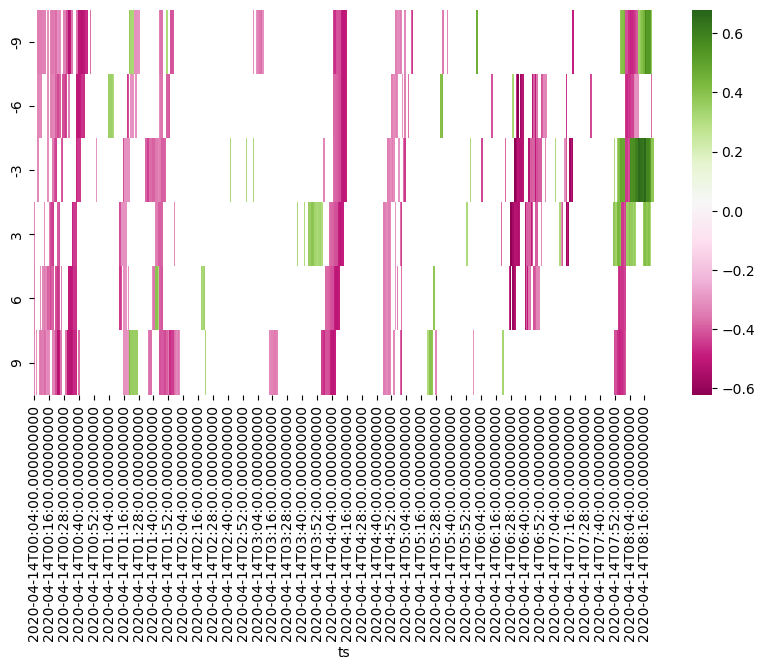

In [54]:
# import matplotlib.dates as dates
# plt.figure(figsize=(10,5))
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(cc_matr.T, cmap="PiYG")


In [32]:
df_pivot

1        2        3
ts                                            
2020-01-01 20:01:00  128.296  3239.75  14497.5
2020-01-01 20:02:00  128.296  3239.50  14512.5
2020-01-01 20:03:00  128.296  3239.75  14515.0
2020-01-01 20:04:00  128.296  3240.00  14510.0
2020-01-01 20:05:00  128.296  3240.00  14512.5
...                      ...      ...      ...
2021-11-30 21:15:00      NaN  4594.75  15355.0
2021-11-30 21:16:00      NaN  4594.75  15355.0
2021-11-30 21:17:00      NaN  4595.50  15365.0
2021-11-30 21:18:00  131.109  4594.75  15363.0
2021-11-30 21:19:00  131.109  4596.00  15377.0

[684156 rows x 3 columns]